### CLUSTERING AND CLASSIFYING LINKEDIN JOBS DESCRIPTIONS WITH WORD COUNTS AND ZERO-SHOT TEXT CLASSIFICATION

In [81]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from openai import OpenAI
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
import pandas as pd
import random
import textwrap
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import re
import os
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import json

import sys
sys.path.append("./src")
import env_options
dotenv_path = "../../apis/.env"
hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=False, use_dotenv=True, dotenv_path=dotenv_path)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


## Loading and filtering the dataset

In [82]:
streaming = False

lmsys_dataset = load_dataset(
  'datastax/linkedin_job_listings',
  revision="main",
  token=hf_token,
  streaming=streaming
)
print(lmsys_dataset)

if not streaming:
  print('Data is cached at:\n')
  for file_info in lmsys_dataset['train'].cache_files:
      filename = file_info['filename']
      file_size = os.path.getsize(filename)
      i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
      print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")


DatasetDict({
    train: Dataset({
        features: ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
        num_rows: 123849
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\datastax___linkedin_job_li*n_job_listings-train-00000-of-00002.arrow
Size: 507321168 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\datastax___linkedin_job_li*n_job_listings-train-00001-of-00002.arrow
Size: 18887864 bytes


In [84]:
sampling= False
n_samples = 1000
if sampling:
    df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
else:
    df_sample = lmsys_dataset['train'].to_pandas()
print(f"Retrieved {len(df_sample)} records. Sample:")
display(df_sample.sample(2))

Retrieved 123849 records. Sample:


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
33442,3895209194,KARL STORZ United States,"Sales Associate, Sacramento",I. Job Purpose\n\nOur Sales Associate is an en...,NaN,None,"Sacramento, CA",14376.0,4.0,NaN,...,None,1.712864e+12,career.karlstorz.com,0,FULL_TIME,None,None,NaN,95811.0,6067.0
67597,3902755699,AECOM,Senior Structural Bridge Engineer,\nCompany Description\n \nWork with Us. Change...,200000.0,YEARLY,"Piscataway, NJ",15656.0,8.0,NaN,...,None,1.713395e+12,rr.jobsyn.org,0,FULL_TIME,USD,BASE_SALARY,165000.0,8854.0,34023.0


In [85]:
work_type = 'FULL_TIME' # 'CONTRACT', 'PART_TIME', 'FULL_TIME'
max_char_length = 2000
extracted_data = df_sample[
    (df_sample['work_type'] == work_type) & 
    (df_sample['description'].str.len() < max_char_length)
]
df_descriptions = extracted_data[['company_name', 'title', 'description', 'location', 'work_type']].copy()
print(f"Retrieved {len(df_descriptions)} {work_type} records. Sample:")
display(df_descriptions.sample(2))

Retrieved 18281 FULL_TIME records. Sample:


,company_name,title,description,location,work_type
69385,Astrix,Project Manager,Job Description:Our client is seeking a experi...,"Ridgefield, CT",FULL_TIME
97083,Insight Global,Chemical Engineer,"Position: Chemical EngineerLocation: Loveland,...","Loveland, CO",FULL_TIME


In [86]:
descr_sample = df_descriptions.sample(1)['description'].values[0]
wrapped_descr = textwrap.fill(descr_sample, width=120)
print(wrapped_descr)

Distribution Design Engineer Type: Full-Time, Perm Work Setting: Remote Our client is seeking an experienced
Distribution Engineer in multiple locations (must be a PE in the state of Georgia). Independently providing engineering
and technical expertise, this role will aid in supporting the implementation of projects among their distribution
design/engineering clients. Education/Experience: • Bachelor’s degree in engineering from an accredited university • 5+
years’ experience in Engineering discipline - Power Distribution (overhead/underground) • Professional Engineer (PE)
certification required• Practices and knowledge of design issues, researching engineering, evaluating alternatives,
making sound recommendations, and preparing and presenting recommendations. • Experience planning, organizing,
scheduling, estimating, and monitoring work activities. • Ability to construct and execute thorough and accurate
technical reports, documentation, correspondence, sketches, and calculations.  R

### Zero-shot classification of jobs

In [87]:
nli_model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft')
nli_tokenizer = AutoTokenizer.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft')
print(nli_model.classification_head.out_proj)
print(nli_model.config.id2label)

Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


Use this cell to classify any text with a zero-shot approach:
- It selects a random job description from df_descriptions.
- zs_classifier uses reddgr/zero-shot-prompt-classifier-bart-ft to categorize the job description into candidate_labels.
- The top predicted label is shown (with its confidence score).
- To adjust the classification output, just swap in different candidate_labels

In [99]:
zs_classifier = pipeline("zero-shot-classification", model=nli_model, tokenizer=nli_tokenizer, device=0)
sample_record = df_descriptions.sample(1)
full_sample = sample_record['description'].values[0]
wrapped_message = textwrap.fill(full_sample, width=120)
candidate_labels = [
    "Marketing",
    "Technology",
    "Sales",
    "Finance",
    "Engineering",  
    "Operations",
    "Human Resources",
    "Administrative",
    "Customer Service",
    "Legal"
]
sentence = [full_sample]
result = zs_classifier(sentence, candidate_labels, multi_label=False)
clear_output(wait=True) # remove library warnings
wrapped_content = textwrap.fill(result[0]["sequence"], width=120)
print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')
print(f'Sorted labels: {result[0]["labels"]}')
print(f'full scores: {[f"{score:.2f}" for score in result[0]["scores"]]}')
print(f'Text:\n{wrapped_content}')

Label: Marketing (score: 0.34)
Sorted labels: ['Marketing', 'Sales', 'Human Resources', 'Customer Service', 'Legal', 'Operations', 'Administrative', 'Finance', 'Technology', 'Engineering']
full scores: ['0.34', '0.30', '0.14', '0.05', '0.05', '0.03', '0.03', '0.02', '0.02', '0.02']
Text:
We are an interactive marketing firm in the area seeking hard working individuals to join our expanding team. WE HAVE
IMMEDIATE OPENINGS IN THE FOLLOWING DEPARTMENTS: SALESMARKETINGPROMOTIONSEVENTSHUMAN RESOURCES CROSS TRAINING is
essential to success in our industry. Regardless of your position, you will receive hands on training in each facet of
our business to solidify your path to advancement. REQUIREMENTS: High School Diploma or GEDMust have a valid Driver’s
LicensePass a Background CheckImmediately available and localMust have a positive attitudeExcellent communication skills
Your success is our success, so our commitment is to provide you with everything you need to evolve into a leader. We
offe

_____________________

### Job descriptions statistics

Code inspired by this article:
https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327

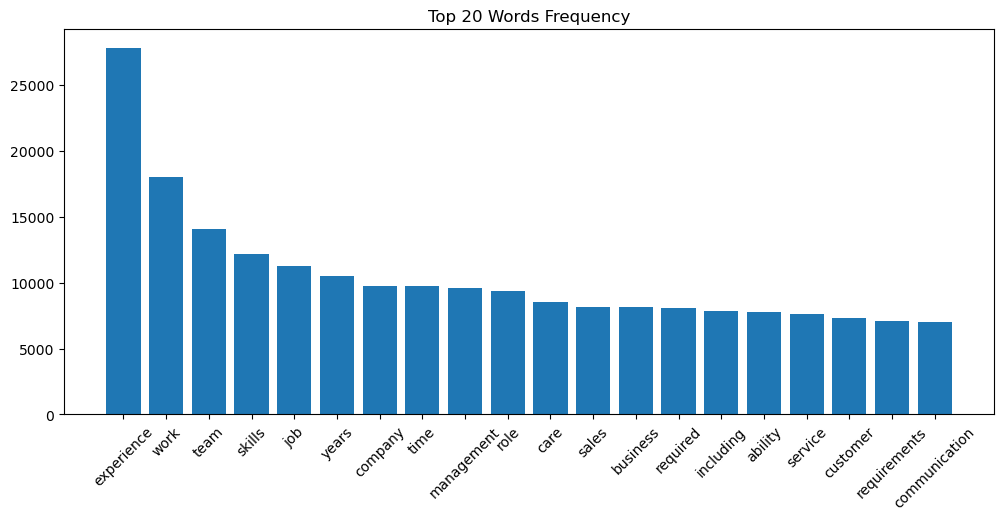

In [95]:
# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
data = df_descriptions['description'].tolist()
X_counts = vectorizer.fit_transform(data)

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Histogram with the most frequent words
top_n_words = 20
words = [wf[0] for wf in word_freq[:top_n_words]]
counts = [wf[1] for wf in word_freq[:top_n_words]]
plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title(f"Top {top_n_words} Words Frequency")
plt.show()

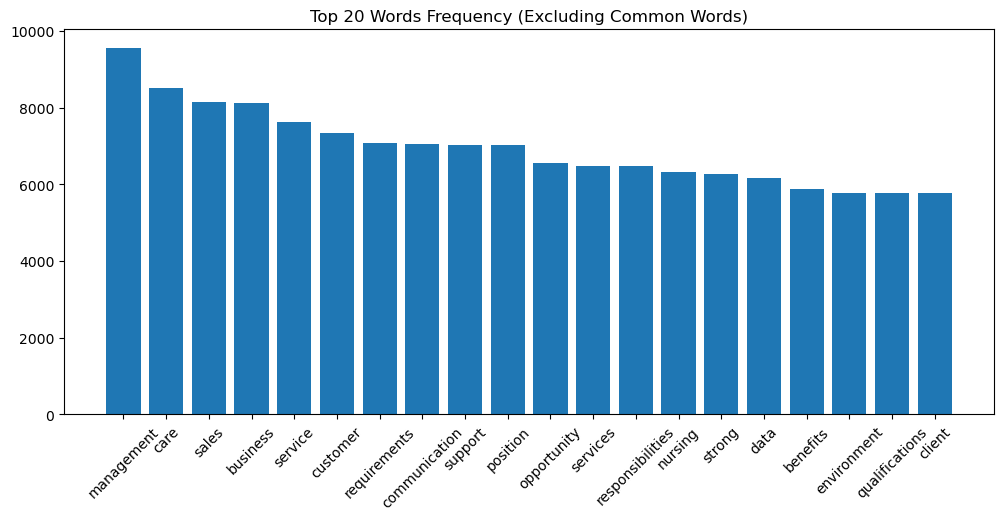

In [96]:
excluded_words = ['experience', 'work', 'team', 'skills', 'job', 'years',
                               'company', 'role', 'required', 'including', 'ability', 'high',
                               'day', 'able', 'knowledge', 'provide', 'working', 'time', 'new']

word_freq = [wf for wf in word_freq if wf[0] not in excluded_words and not wf[0].startswith('name_')]

word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Histogram with the most frequent words
top_n_words = 20
words = [wf[0] for wf in word_freq[:top_n_words]]
counts = [wf[1] for wf in word_freq[:top_n_words]]
plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title(f"Top {top_n_words} Words Frequency (Excluding Common Words)")
plt.show()

In [97]:
# Save word frequency to a DataFrame
df_word_freq = pd.DataFrame(word_freq, columns=['word', 'frequency'])
display(df_word_freq.head(10))
# Save the DataFrame to a pickle file
df_word_freq.to_pickle('pkl/word_freq_diltered.pkl')

,word,frequency
0,management,9559
1,care,8519
2,sales,8151
3,business,8121
4,service,7630
5,customer,7327
6,requirements,7085
7,communication,7038
8,support,7017
9,position,7016


In [98]:
# Display top 100 words in a 10x10 grid
for i in range(0, 100, 10):
    print(df_word_freq['word'].iloc[i:i+10].to_list())

['management', 'care', 'sales', 'business', 'service', 'customer', 'requirements', 'communication', 'support', 'position']
['opportunity', 'services', 'responsibilities', 'nursing', 'strong', 'data', 'benefits', 'environment', 'qualifications', 'client']
['degree', 'development', 'preferred', 'related', 'description', 'responsible', 'health', 'quality', 'clients', 'medical']
['project', 'seeking', 'information', 'financial', 'join', 'office', 'training', 'looking', 'accounting', 'industry']
['ensure', 'design', 'patients', 'manager', 'duties', 'professional', 'school', 'patient', 'excellent', '000']
['maintain', 'apply', 'insurance', 'systems', 'based', 'healthcare', 'process', 'assist', 'year', 'state']
['software', 'nurse', 'technical', 'construction', 'projects', 'staff', 'equipment', 'customers', 'solutions', 'opportunities']
['providing', 'license', 'firm', 'career', 'engineering', 'paid', 'field', 'pay', 'dental', 'education']
['marketing', 'candidate', 'manage', 'include', 'leve

### TF-IDF vectorization

In [30]:
df = df_descriptions[['description']].copy()
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words and word not in excluded_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['description'].apply(preprocess_text)
display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,description,clean_text
2,The National Exemplar is accepting application...,nation exemplar accept applic assist restaur m...
3,Senior Associate Attorney - Elder Law / Trusts...,senior associ attorney elder law trust estat l...
4,Looking for HVAC service tech with experience ...,look hvac servic tech experi commer industri e...
10,Glastender Inc. is a family-owned manufacturer...,glastend inc famili own manufactur commerci ba...
11,PGAV Destinations is seeking a self-motivated ...,pgav destin seek self motiv high creativ indiv...
...,...,...
123798,This is a full time job with our Fortune clien...,full time job fortun client person need base h...
123808,Our client is looking for an Estimator to join...,client look estim join team client union carpe...
123814,Our Walnut Creek office is currently seeking a...,walnut creek offic current seek generalist edu...
123822,"Job Description\n\nWill be note taking, buildi...",job descript note take build slide manag trans...


In [31]:
# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
print(X_tfidf.shape)

(18281, 5000)


### K-means Clustering

In [76]:
# Apply K-Means with a predetermined number of clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_+1
df['cluster_kmeans'] = labels_kmeans
display(df)

,description,clean_text,cluster_kmeans
2,The National Exemplar is accepting application...,nation exemplar accept applic assist restaur m...,5
3,Senior Associate Attorney - Elder Law / Trusts...,senior associ attorney elder law trust estat l...,5
4,Looking for HVAC service tech with experience ...,look hvac servic tech experi commer industri e...,5
10,Glastender Inc. is a family-owned manufacturer...,glastend inc famili own manufactur commerci ba...,4
11,PGAV Destinations is seeking a self-motivated ...,pgav destin seek self motiv high creativ indiv...,7
...,...,...,...
123798,This is a full time job with our Fortune clien...,full time job fortun client person need base h...,2
123808,Our client is looking for an Estimator to join...,client look estim join team client union carpe...,5
123814,Our Walnut Creek office is currently seeking a...,walnut creek offic current seek generalist edu...,5
123822,"Job Description\n\nWill be note taking, buildi...",job descript note take build slide manag trans...,5


2-D visualization of clusters distances:

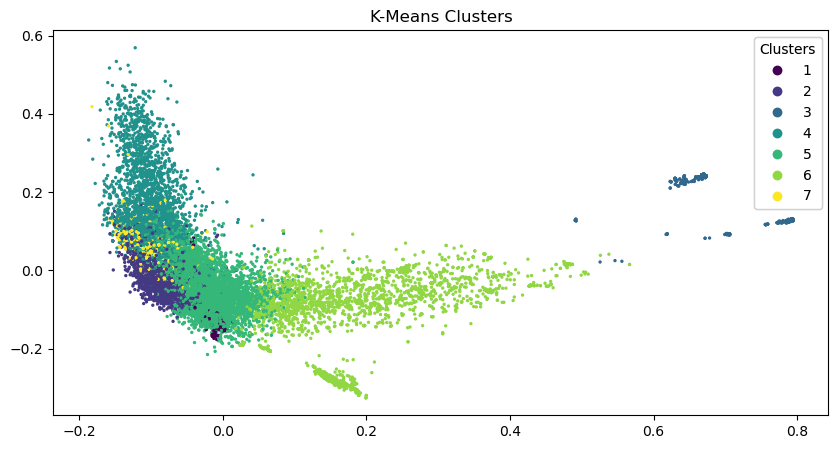

In [77]:
# Function to plot clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())
# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')

### Word frequency histograms per cluster

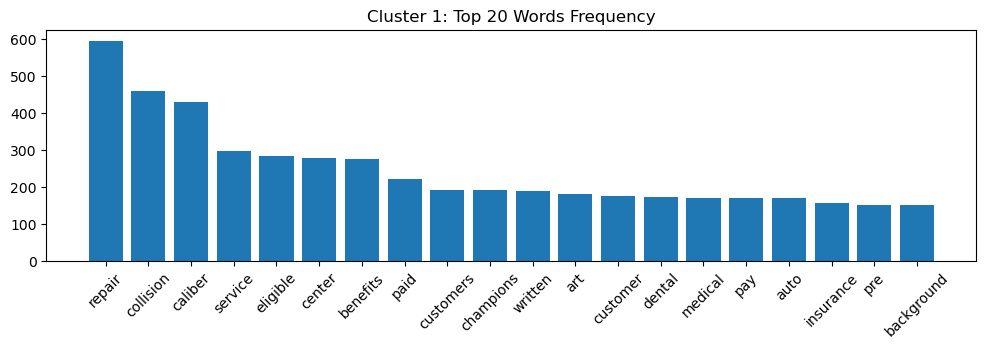

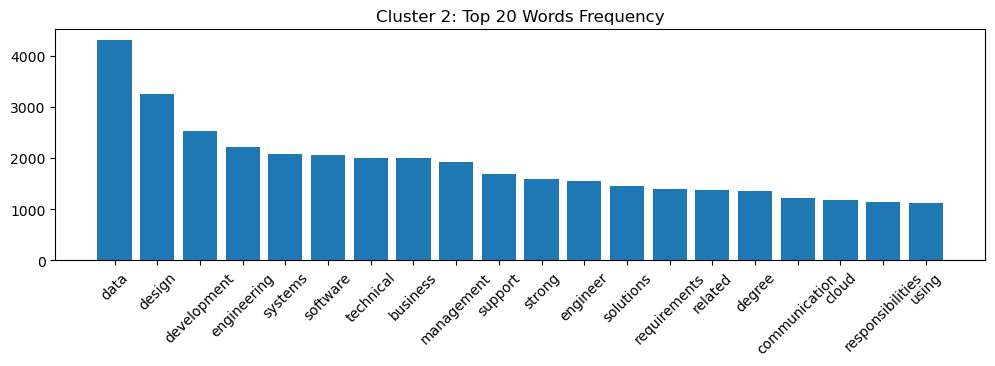

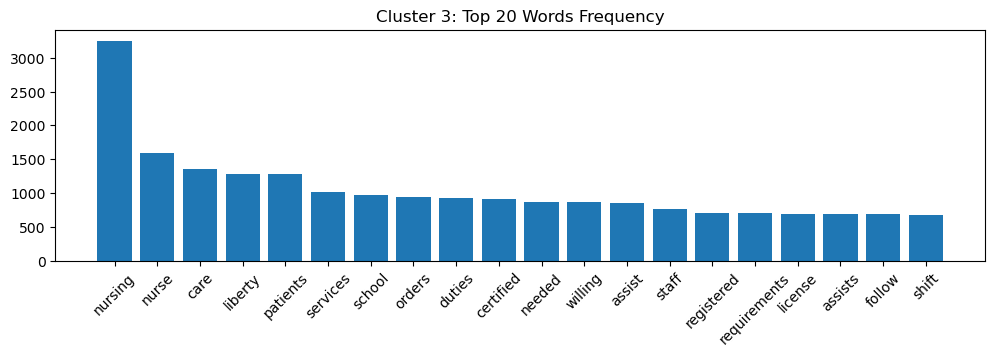

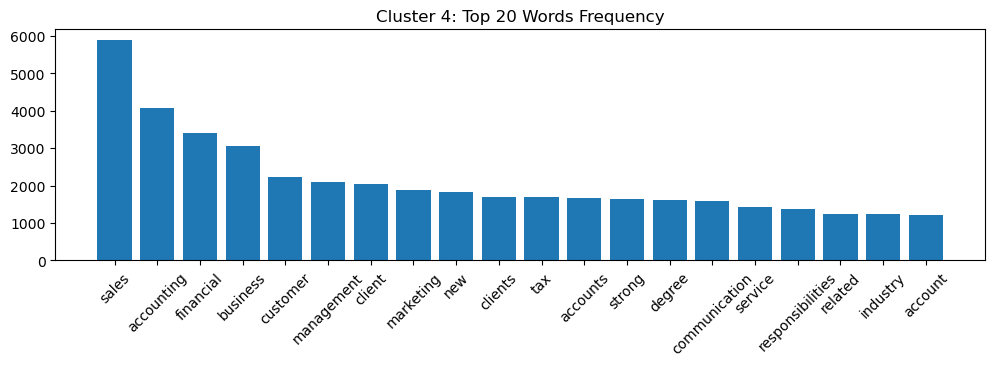

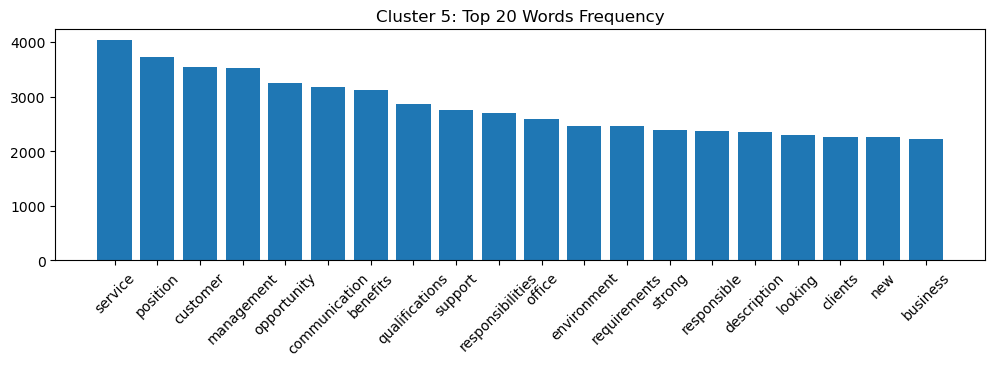

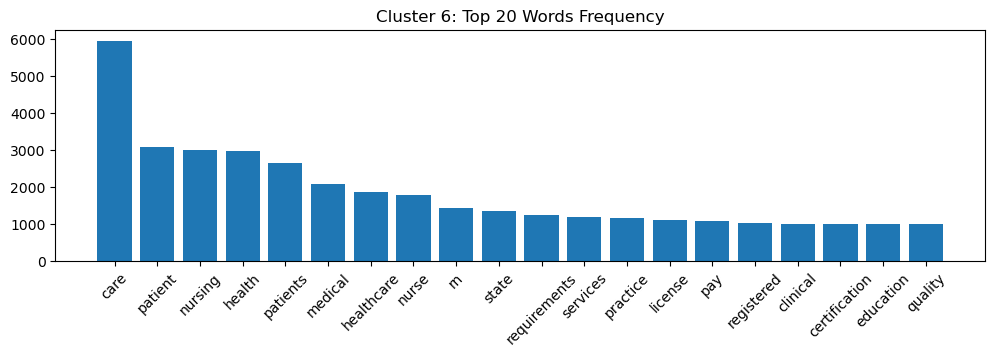

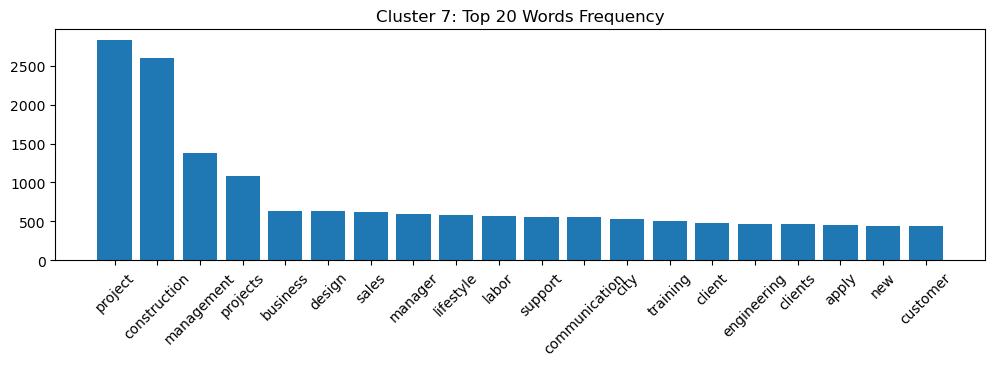

In [78]:
# Store words for each cluster in a list of lists
clusters_top_words = []
clusters_top_counts = []

# Get the raw word count matrix for each cluster
for cluster_id in range(1, num_clusters+1):
    # Filter the rows corresponding to the current cluster
    cluster_data = df[df['cluster_kmeans'] == cluster_id]['description']
    
    # Vectorize the text data for this cluster
    cluster_counts = vectorizer.transform(cluster_data)
    cluster_word_counts = cluster_counts.toarray().sum(axis=0)
    
    # Compute word frequencies for the current cluster
    cluster_word_freq = [(word, cluster_word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    cluster_word_freq = sorted(cluster_word_freq, key=lambda x: x[1], reverse=True)

    # Filter out the excluded words
    histogram_excluded_words =['experience', 'work', 'team', 'skills', 'job', 'years',
                               'company', 'role', 'required', 'including', 'ability', 'high',
                               'day', 'able', 'knowledge', 'provide', 'working', 'time', 'new']
    cluster_word_freq = [wf for wf in cluster_word_freq if wf[0] not in histogram_excluded_words and not wf[0].startswith('name_')]
    
    # Select top N terms for plotting
    top_n_words = 20
    words = [wf[0] for wf in cluster_word_freq[:top_n_words]]
    counts = [wf[1] for wf in cluster_word_freq[:top_n_words]]
    

    clusters_top_words.append(words.copy())
    clusters_top_counts.append(counts.copy())
    
    # Plot the histogram for the current cluster
    plt.figure(figsize=(12, 3))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster_id}: Top {top_n_words} Words Frequency")
    plt.show()


### Cluster identification with LLM

We use the OpenAI API and structured outputs to come up with meaningful, relevant terms for the clusters.

In [79]:
client = OpenAI(api_key=openai_api_key)

# Define the function schema for structured output
categories_function = {
    "name": "categories_function",
    "description": "Return a JSON object with a 'categories' array containing exactly {num_clusters} items",
    "parameters": {
        "type": "object",
        "properties": {
            "categories": {
                "type": "array",
                "description": "List of category strings, one for each cluster",
                "items": {
                    "type": "string"
                }
            }
        },
        "required": ["categories"]
    }
}

lines = []
for i, cluster_words in enumerate(clusters_top_words, start=1):
    lines.append(f"Cluster {i}: {', '.join(cluster_words)}")

clusters_str = "\n".join(lines)

prompt_template = (
    "You are a job categorization assistant. Given these {num_clusters} clusters of important words,\n"
    "respond with exactly {num_clusters} distinct, broad job categories, that cover as much of the spectrum of existing jobs, in JSON. Provide answer using\n"
    "the 'categories_function' call.\n\n{clusters_str}. "
    " Remember the categories much cover as many job categories as possible, so they should be distinct to each other." \
    " For example, 'Healthcare management' and 'Healthcare administration' are too similar to be separate categories."
)

prompt = prompt_template.format(
    num_clusters=len(clusters_top_words),
    clusters_str=clusters_str
)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    functions=[categories_function],
    function_call={"name": "categories_function"},
    temperature=0.7
)

try:
    # Extract the function call arguments
    args_json = response.choices[0].message.function_call.arguments
    categories_data = json.loads(args_json)
    print("\nAssigned Categories (Structured):")
    print(categories_data["categories"])
except (json.JSONDecodeError, KeyError):
    print("\nCould not parse JSON. Raw output:")
    print(response)

for i, cluster in enumerate(clusters_top_words):
    print(f"Cluster {i+1} top words:", cluster)


Assigned Categories (Structured):
['Automotive Service and Repair', 'Information Technology and Engineering', 'Healthcare Services', 'Sales and Marketing', 'Customer Service and Support', 'Nursing and Patient Care', 'Project Management and Construction']
Cluster 1 top words: ['repair', 'collision', 'caliber', 'service', 'eligible', 'center', 'benefits', 'paid', 'customers', 'champions', 'written', 'art', 'customer', 'dental', 'medical', 'pay', 'auto', 'insurance', 'pre', 'background']
Cluster 2 top words: ['data', 'design', 'development', 'engineering', 'systems', 'software', 'technical', 'business', 'management', 'support', 'strong', 'engineer', 'solutions', 'requirements', 'related', 'degree', 'communication', 'cloud', 'responsibilities', 'using']
Cluster 3 top words: ['nursing', 'nurse', 'care', 'liberty', 'patients', 'services', 'school', 'orders', 'duties', 'certified', 'needed', 'willing', 'assist', 'staff', 'registered', 'requirements', 'license', 'assists', 'follow', 'shift']


### Histograms for named clusters

['Automotive Service and Repair', 'Information Technology and Engineering', 'Healthcare Services', 'Sales and Marketing', 'Customer Service and Support', 'Nursing and Patient Care', 'Project Management and Construction']
[['repair', 'collision', 'caliber', 'service', 'eligible', 'center', 'benefits', 'paid', 'customers', 'champions', 'written', 'art', 'customer', 'dental', 'medical', 'pay', 'auto', 'insurance', 'pre', 'background'], ['data', 'design', 'development', 'engineering', 'systems', 'software', 'technical', 'business', 'management', 'support', 'strong', 'engineer', 'solutions', 'requirements', 'related', 'degree', 'communication', 'cloud', 'responsibilities', 'using'], ['nursing', 'nurse', 'care', 'liberty', 'patients', 'services', 'school', 'orders', 'duties', 'certified', 'needed', 'willing', 'assist', 'staff', 'registered', 'requirements', 'license', 'assists', 'follow', 'shift'], ['sales', 'accounting', 'financial', 'business', 'customer', 'management', 'client', 'marketin

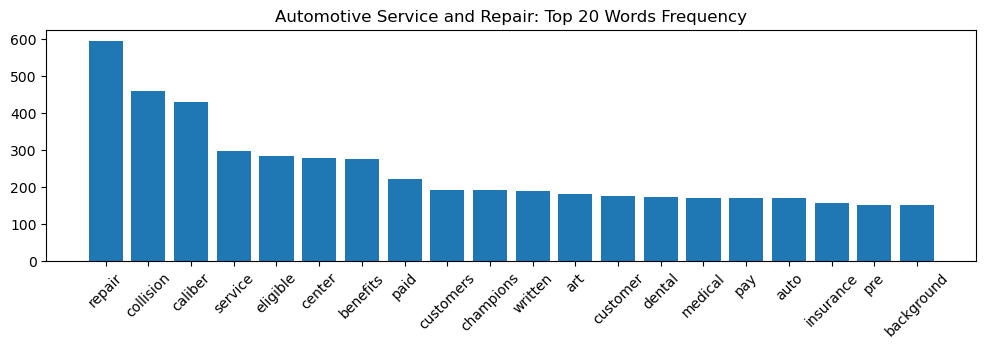

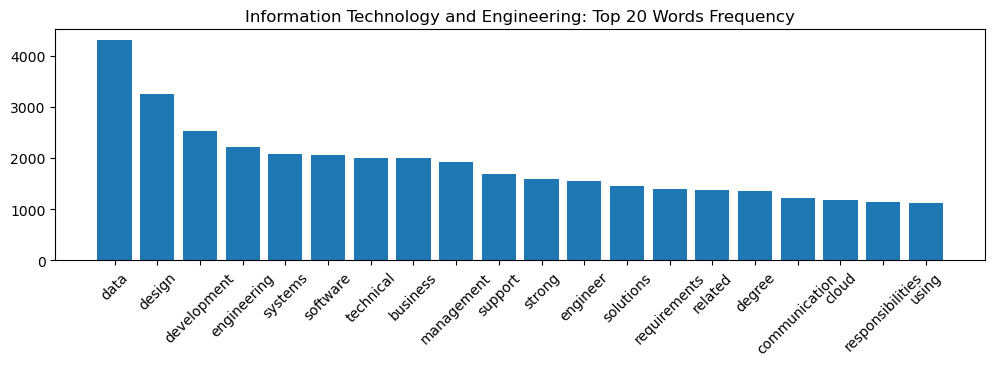

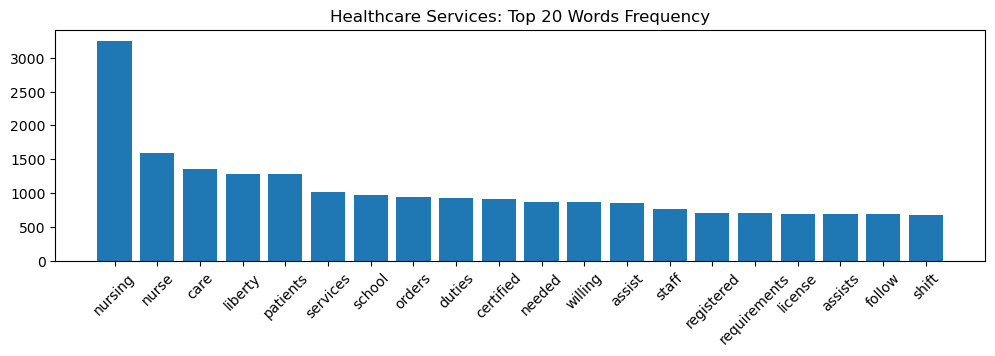

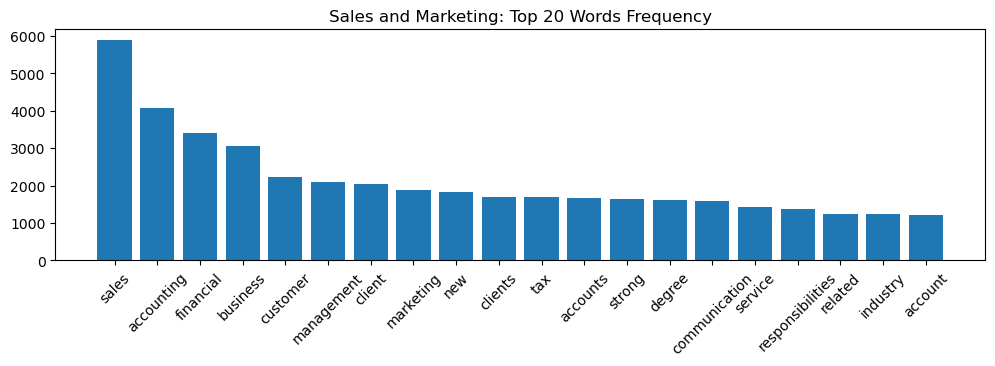

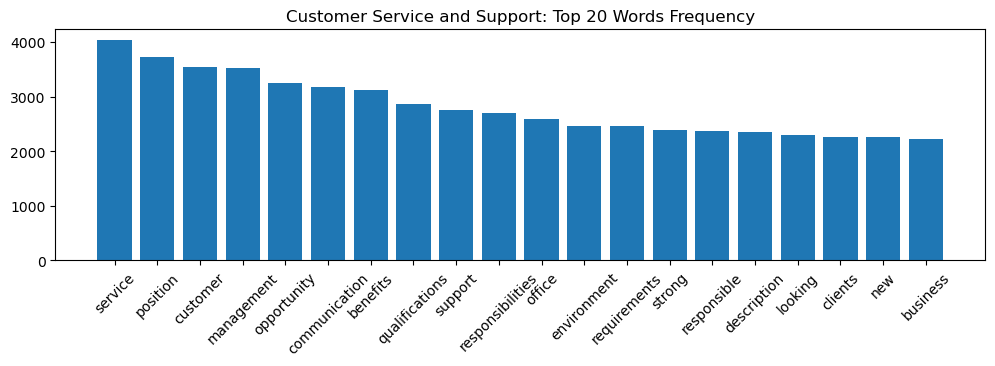

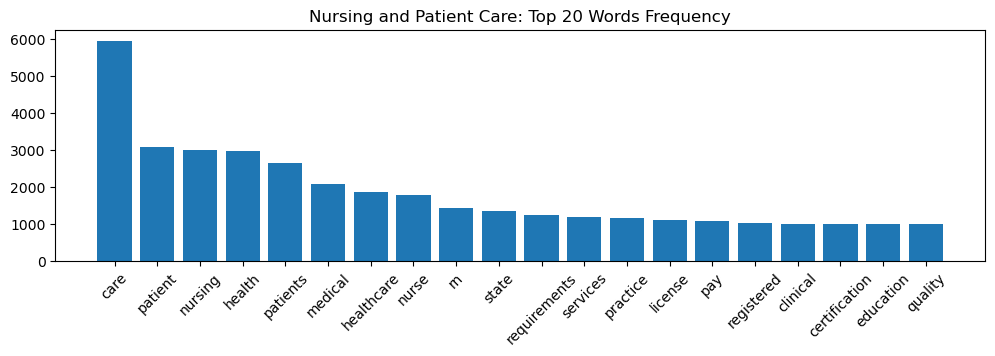

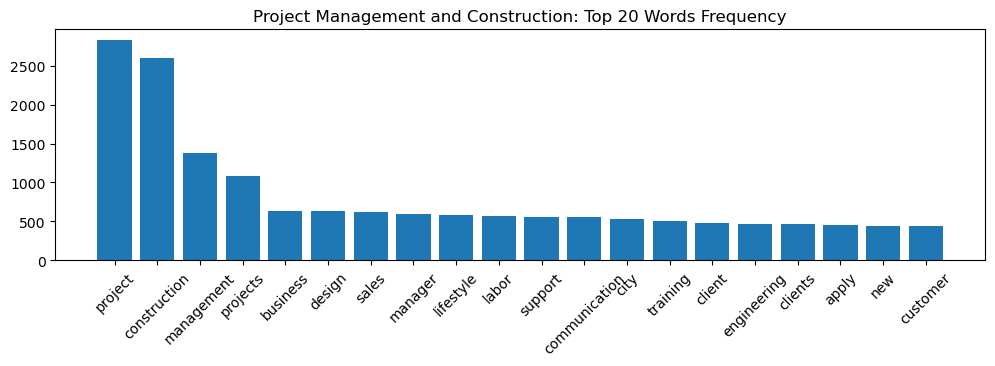

In [80]:
cluster_names = categories_data["categories"]
print(cluster_names)
print(clusters_top_words)
print(clusters_top_counts)

for i, name in enumerate(cluster_names):
    plt.figure(figsize=(12, 3))
    plt.bar(clusters_top_words[i], clusters_top_counts[i])
    plt.xticks(rotation=45)
    plt.title(f"{name}: Top {top_n_words} Words Frequency")
    plt.show()

### Zero-shot job classification for inferred clusters

In [100]:
nli_model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft')
nli_tokenizer = AutoTokenizer.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft')

In [104]:
zs_classifier = pipeline("zero-shot-classification", model=nli_model, tokenizer=nli_tokenizer, device=0)
sample_record = df_descriptions.sample(1)
full_sample = sample_record['description'].values[0]
wrapped_message = textwrap.fill(full_sample, width=120)
sentence = [full_sample]
result = zs_classifier(sentence, cluster_names, multi_label=False) # We use cluster_names obtained with the OpenAI API inference as candidate labels
clear_output(wait=True) # remove library warnings
wrapped_content = textwrap.fill(result[0]["sequence"], width=120)
print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')
print(f'Sorted labels: {result[0]["labels"]}')
print(f'full scores: {[f"{score:.2f}" for score in result[0]["scores"]]}')
print(f'Text:\n{wrapped_content}')

Label: Information Technology and Engineering (score: 0.56)
Sorted labels: ['Information Technology and Engineering', 'Customer Service and Support', 'Project Management and Construction', 'Automotive Service and Repair', 'Sales and Marketing', 'Healthcare Services', 'Nursing and Patient Care']
full scores: ['0.56', '0.23', '0.05', '0.04', '0.04', '0.04', '0.03']
Text:
Company DescriptionObjectways is a boutique shop specializing in solving complex problems in Big Data Analytics, Machine
Learning/Artificial Intelligence, and IoT analytics. We believe in working backward from customer problems to provide
customized solutions using state-of-the-art tools and techniques. Our engagement model is simple, and we provide an
innovative and well-architected approach to platform creation and maintenance. With built-in warranties and dedicated
support, we ensure operational excellence, security, reliability, performance efficiency, and cost optimization. Role
DescriptionThis is a full-time, on-si

_____________________